<a href="https://colab.research.google.com/github/ameliabaier17/ocean_project/blob/main/code/data_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries


In [24]:
import os
print(os.cpu_count())


2


In [3]:
!pip install netCDF4
!pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.4 MB/s eta 0:00:00


In [19]:
import numpy as np
import pandas as pd
import netCDF4
import xarray as xr
import os
import matplotlib.pyplot as plt
import dask
import time
import cartopy.crs as ccrs
import cartopy.feature as cfeature


# Data Exploring

In [5]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# confirm drive contents
!ls "/content/drive/My Drive/Ocean"

adcp-saildrone-gen_5-antarctica_circumnavigation_2019-sd1020-20190119T040000-20190803T043000-1_minutes-v1.1597092482498.nc
data_cleaning.ipynb
surface-saildrone-gen_5-antarctica_circumnavigation_2019-sd1020-20190119T040000-20190803T043000-1_minutes-v1.1620360815446.nc


In [7]:
# read in data
ant_adcp_file = '/content/drive/My Drive/Ocean/adcp-saildrone-gen_5-antarctica_circumnavigation_2019-sd1020-20190119T040000-20190803T043000-1_minutes-v1.1597092482498.nc'
ant_sur_file = '/content/drive/My Drive/Ocean/surface-saildrone-gen_5-antarctica_circumnavigation_2019-sd1020-20190119T040000-20190803T043000-1_minutes-v1.1620360815446.nc'

In [8]:
# use xarray to open netcdf
ds_adcp = xr.open_dataset(ant_adcp_file)
adcp_vars = list(ds_adcp.variables)
print("adcp data:\n",adcp_vars,"\n")

ds_sur = xr.open_dataset(ant_sur_file)
sur_vars = list(ds_sur.variables)
print("surface data:\n",sur_vars,"\n")

adcp data:
 ['trajectory', 'cell_depth', 'time', 'latitude', 'longitude', 'roll', 'pitch', 'heading', 'vel_east', 'vel_north', 'vel_up', 'error_vel', 'echo_intensity', 'correlation', 'nav_start_time', 'nav_end_time', 'nav_start_latitude', 'nav_end_latitude', 'nav_start_longitude', 'nav_end_longitude', 'vehicle_vel_north', 'vehicle_vel_east', 'vehicle_vel_up', 'bt_range', 'bt_cor', 'bt_vel_east', 'bt_vel_north', 'bt_vel_up', 'bt_amp', 'bt_percent_good', 'percent_good_4_beam', 'percent_good_3_beam', 'percent_good'] 

surface data:
 ['SOG', 'COG', 'HDG', 'HDG_WING', 'WING_ANGLE', 'UWND_MEAN', 'UWND_STDDEV', 'VWND_MEAN', 'VWND_STDDEV', 'WWND_MEAN', 'WWND_STDDEV', 'GUST_WND_MEAN', 'GUST_WND_STDDEV', 'WIND_MEASUREMENT_HEIGHT_MEAN', 'WIND_MEASUREMENT_HEIGHT_STDDEV', 'TEMP_AIR_MEAN', 'TEMP_AIR_STDDEV', 'RH_MEAN', 'RH_STDDEV', 'BARO_PRES_MEAN', 'BARO_PRES_STDDEV', 'PAR_AIR_MEAN', 'PAR_AIR_STDDEV', 'TEMP_IR_SEA_WING_UNCOMP_MEAN', 'TEMP_IR_SEA_WING_UNCOMP_STDDEV', 'WAVE_DOMINANT_PERIOD', 'WAVE_SI

In [22]:
# create function to pull stats for xarray data variables:
def var_summary(ds, variable):
  var = ds[variable]

  stats = {'min': var.min().item(),
           'max': var.max().item(),
           'mean': var.mean().item(),
           'median': var.median().item(),
           'std': var.std().item(),
           'total vals': var.count().item(),
           'missing vals': np.isnan(var).sum().item()}

  return stats

In [85]:
# explore adcp and surface variables

sur_var_list = ['CHLOR_RBR_MEAN','SAL_RBR_MEAN','O2_CONC_RBR_MEAN','PAR_AIR_MEAN','TEMP_CTD_RBR_MEAN','WAVE_SIGNIFICANT_HEIGHT','WWND_MEAN']
print("SURFACE VARIABLES:")
for var in sur_var_list:
  print(f"{var}:\n",var_summary(ds_sur, var))


adcp_var_list = ['vel_east','vel_north','vel_up','error_vel', 'longitude','latitude','cell_depth']
print("\nADCP VARIABLES:")
for var in adcp_var_list:
    print(f"{var}:\n", var_summary(ds_adcp, var))

# surface values are far fewer than adcp values
# some surface values have barely any data - related to march 7th surface sensor accident?

SURFACE VARIABLES:
CHLOR_RBR_MEAN:
 {'min': 0.1524, 'max': 593.005, 'mean': 5.890829873830939, 'median': 1.8987, 'std': 24.678477592184322, 'total vals': 229137, 'missing vals': 53134}
SAL_RBR_MEAN:
 {'min': 29.916, 'max': 34.96, 'mean': 34.050855313633335, 'median': 33.989, 'std': 0.263266705422514, 'total vals': 229137, 'missing vals': 53134}
O2_CONC_RBR_MEAN:
 {'min': 239.77, 'max': 327.82, 'mean': 290.47169863444134, 'median': 294.32, 'std': 16.089129620771068, 'total vals': 229137, 'missing vals': 53134}
PAR_AIR_MEAN:
 {'min': 0.0, 'max': 2619.0, 'mean': 277.1090910937548, 'median': 59.0, 'std': 419.16421367345146, 'total vals': 98459, 'missing vals': 183812}
TEMP_CTD_RBR_MEAN:
 {'min': -0.758, 'max': 15.997, 'mean': 4.844974761823713, 'median': 4.062, 'std': 3.1824408077785376, 'total vals': 229137, 'missing vals': 53134}
WAVE_SIGNIFICANT_HEIGHT:
 {'min': 0.537, 'max': 11.958, 'mean': 4.133511344952318, 'median': 3.919, 'std': 1.4962669502189898, 'total vals': 9123, 'missing vals

In [79]:
# metadata on specific vars
print("SURFACE VARIABLES:")
for var in sur_var_list:
  variable = ds_sur[var]
  print(variable.attrs)

print("\nADCP VARIABLES:")
for var in adcp_var_list:
  variable = ds_adcp[var]
  print(variable.attrs)


SURFACE VARIABLES:
{'standard_name': 'mass_concentration_of_chlorophyll_in_sea_water', 'long_name': 'Chlorophyll concentration', 'units': 'microgram L-1', 'installed_date': '2018-11-01T00:00:00Z', 'device_name': 'RBR CTD/ODO/Chl-A (40804)', 'serial_number': '40804', 'last_calibrated': '2018-10-19', 'installed_height': -0.5, 'vendor_name': 'RBR', 'model_name': 'Saildrone^3', 'nominal_sampling_schedule': '12s on, 48s off, centered at :00', 'update_period': 500.0}
{'standard_name': 'sea_water_practical_salinity', 'long_name': 'Seawater salinity', 'units': '1', 'installed_date': '2018-11-01T00:00:00Z', 'device_name': 'RBR CTD/ODO/Chl-A (40804)', 'serial_number': '40804', 'last_calibrated': '2018-10-19', 'installed_height': -0.5, 'vendor_name': 'RBR', 'model_name': 'Saildrone^3', 'nominal_sampling_schedule': '12s on, 48s off, centered at :00', 'update_period': 500.0}
{'standard_name': 'mole_concentration_of_dissolved_molecular_oxygen_in_sea_water', 'long_name': 'Oxygen concentration', 'unit

SURFACE VARIABLES:


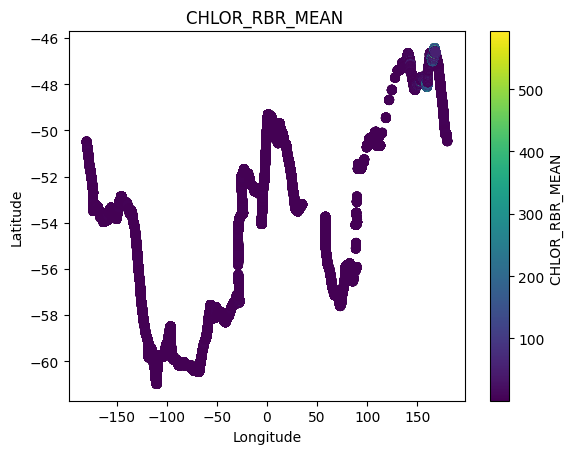

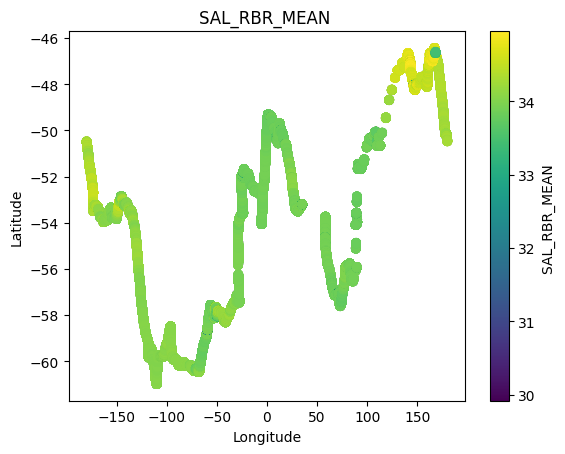

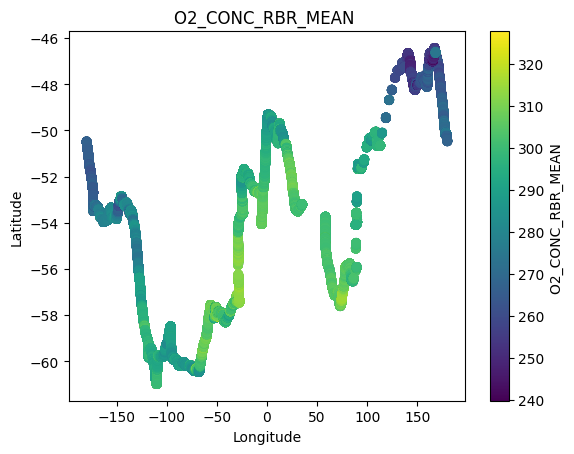

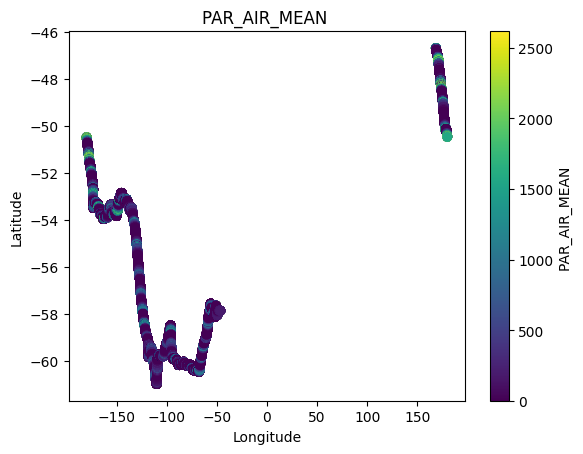

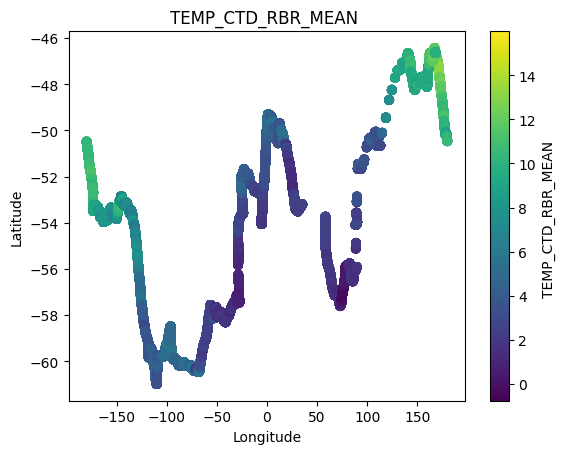

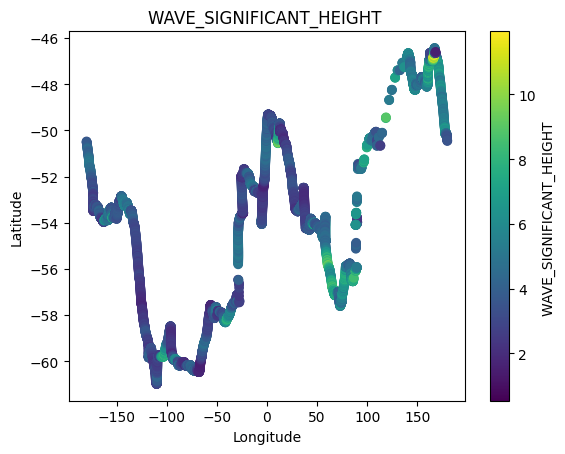

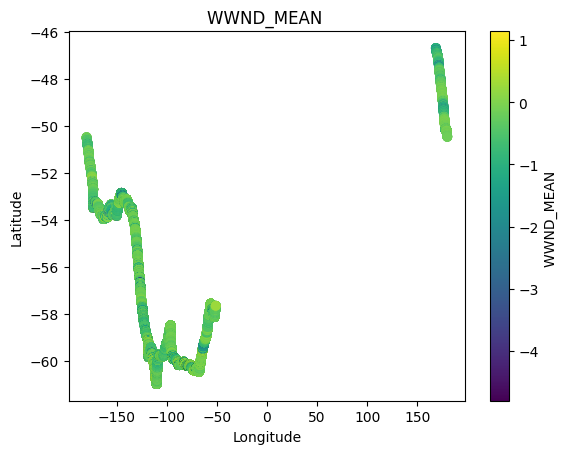


ADCP VARIABLES:


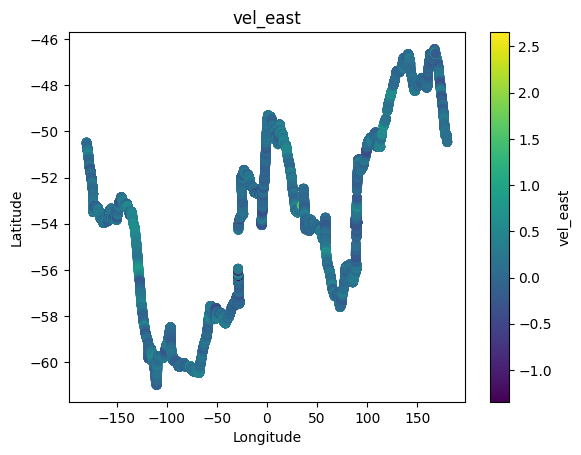

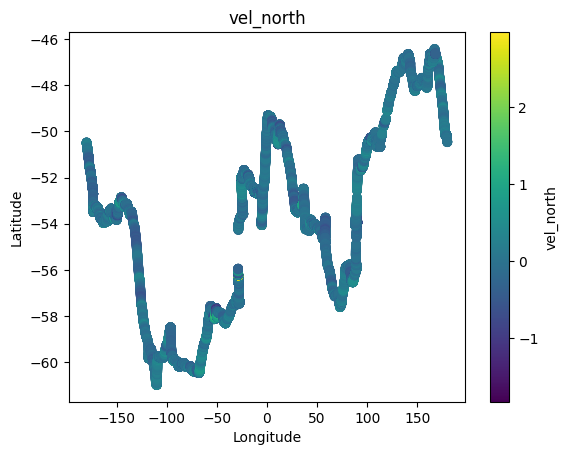

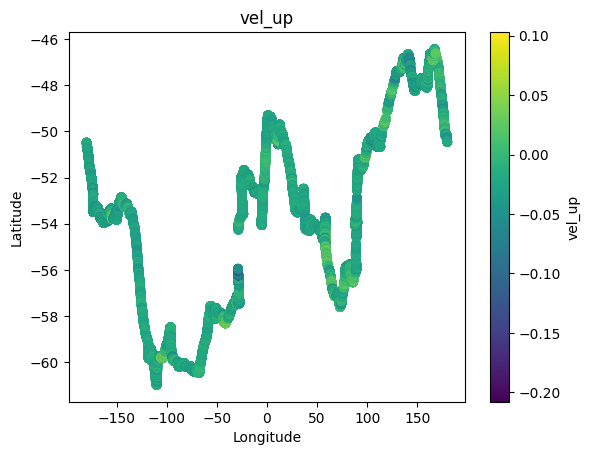

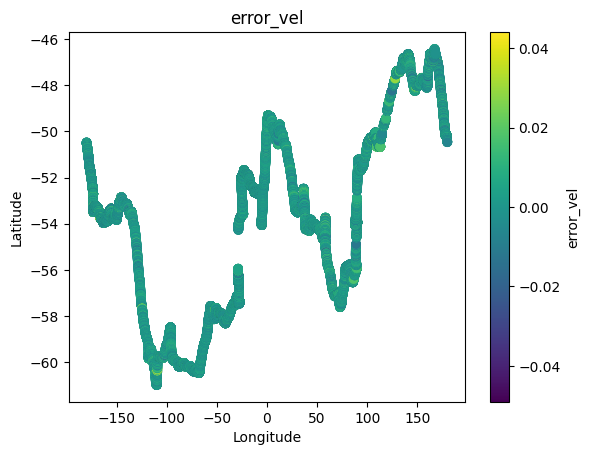

In [94]:
# plotting
longitude = ds_sur['longitude'][0, :]
latitude = ds_sur['latitude'][0, :]

print("SURFACE VARIABLES:")
for var in sur_var_list:
  plt.scatter(longitude, latitude, c=ds_sur[var], cmap='viridis')
  plt.colorbar(label=f"{var} ")
  plt.title(f"{var} ")
  plt.xlabel('Longitude')
  plt.ylabel('Latitude')
  plt.show()

print("\nADCP VARIABLES:")
longitude = ds_adcp['longitude'][0, :]
latitude = ds_adcp['latitude'][0, :]

for var in adcp_var_list[:4]:
  variable = ds_adcp[var][0, :, 0]
  plt.scatter(longitude, latitude, c=variable, cmap='viridis')
  plt.colorbar(label=f"{var}")
  plt.title(f"{var}")
  plt.xlabel('Longitude')
  plt.ylabel('Latitude')
  plt.show()


Longitude has NaN: True
Latitude has NaN: True
Longitude has Inf: False
Latitude has Inf: False


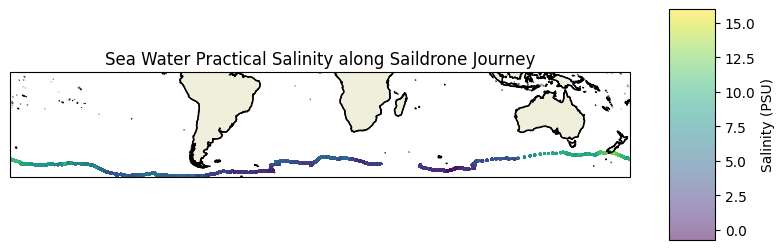

In [82]:
longitude = ds_sur['longitude'].values.flatten()
latitude = ds_sur['latitude'].values.flatten()
salinity = ds_sur['TEMP_CTD_RBR_MEAN'].values.flatten()

import numpy as np

# Check for NaN or Inf in longitude and latitude
print("Longitude has NaN:", np.any(np.isnan(longitude)))
print("Latitude has NaN:", np.any(np.isnan(latitude)))
print("Longitude has Inf:", np.any(np.isinf(longitude)))
print("Latitude has Inf:", np.any(np.isinf(latitude)))

# Replace NaN or Inf values if they exist, or remove them
# This is a simple method to replace NaN with a placeholder value (e.g., 0.0), but you might want to handle it differently
longitude = np.nan_to_num(longitude, nan=0.0, posinf=0.0, neginf=0.0)
latitude = np.nan_to_num(latitude, nan=0.0, posinf=0.0, neginf=0.0)

# Creating a figure with a map projection
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())  # Using PlateCarree for simplicity; choose projection as needed
ax.coastlines(resolution='50m')  # Adding coastlines
ax.add_feature(cfeature.LAND, edgecolor='black')  # Adding land feature

# Defining the geographic extent [min longitude, max longitude, min latitude, max latitude]
extent = [np.min(longitude), np.max(longitude), np.min(latitude), np.max(latitude)]
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Plotting the salinity data
sc = ax.scatter(longitude, latitude, c=salinity, cmap='viridis', s=1, transform=ccrs.PlateCarree(), alpha=0.5)

# Adding a colorbar to show the salinity values
cbar = plt.colorbar(sc, shrink=0.5, aspect=5)
cbar.set_label('Salinity (PSU)')

plt.title('Sea Water Practical Salinity along Saildrone Journey')
plt.show()

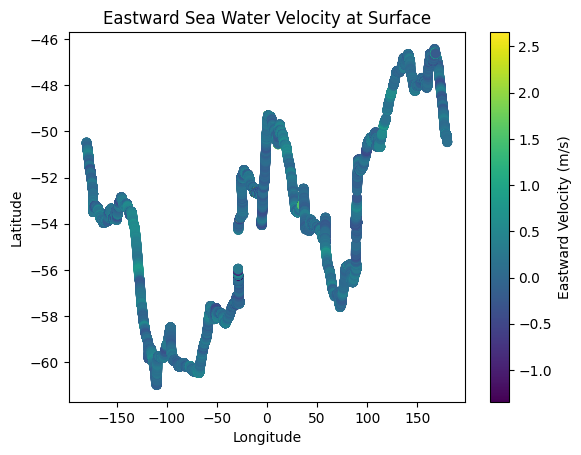

In [46]:
# Selecting the surface layer velocity assuming the first index (0) represents the surface
surface_velocity = ds_adcp['vel_east'][0, :, 0]  # Adjust 0 at the end if another depth level is needed

# Ensuring longitude and latitude are properly shaped for plotting
longitude = ds_adcp['longitude'][0, :]
latitude = ds_adcp['latitude'][0, :]

plt.scatter(longitude, latitude, c=surface_velocity, cmap='viridis')
plt.colorbar(label='Eastward Velocity (m/s)')
plt.title('Eastward Sea Water Velocity at Surface')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


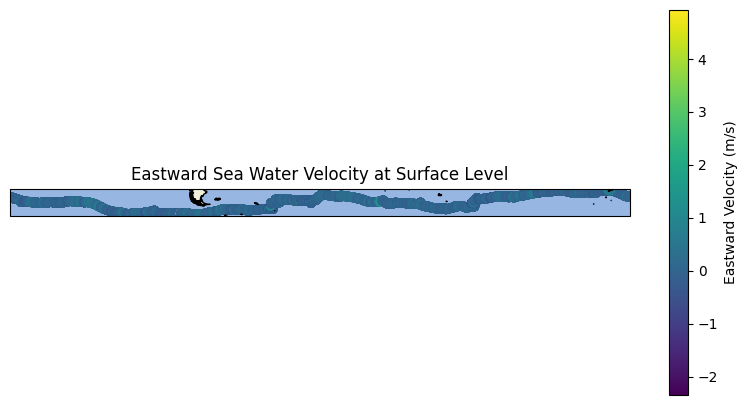

In [52]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Adjusting for available dimensions - selecting the first entry in 'trajectory' if it represents individual journeys
# Assuming 'cell_depth' has a dimension for depth, and you're interested in the surface or a specific depth
# If 'cell_depth' is 0 or another index for the surface, adjust accordingly
surface_velocity = ds_adcp['vel_east'].isel(trajectory=0, cell_depth=49)  # Adjust cell_depth as needed

# Extracting longitude and latitude for the entire journey
longitude = ds_adcp['longitude'].isel(trajectory=0)
latitude = ds_adcp['latitude'].isel(trajectory=0)

# Creating the plot with Cartopy
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)

# Assuming longitude, latitude, and surface_velocity have matching dimensions now
sc = plt.scatter(longitude, latitude, c=surface_velocity, cmap='viridis', transform=ccrs.PlateCarree())

plt.colorbar(sc, label='Eastward Velocity (m/s)')
plt.title('Eastward Sea Water Velocity at Surface Level')
plt.show()


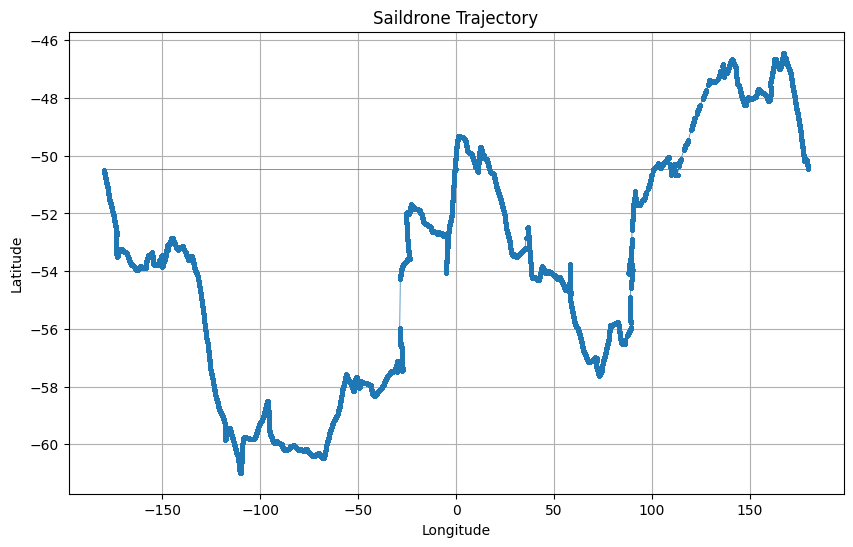

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(df_vel_up['longitude'], df_vel_up['latitude'], marker='o', linestyle='-', markersize=2, linewidth=0.5)
plt.title('Saildrone Trajectory')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

(array([17928., 17956., 17987., 18017., 18048., 18078., 18109.]),
 [Text(17928.0, 0, '2019-02'),
  Text(17956.0, 0, '2019-03'),
  Text(17987.0, 0, '2019-04'),
  Text(18017.0, 0, '2019-05'),
  Text(18048.0, 0, '2019-06'),
  Text(18078.0, 0, '2019-07'),
  Text(18109.0, 0, '2019-08')])

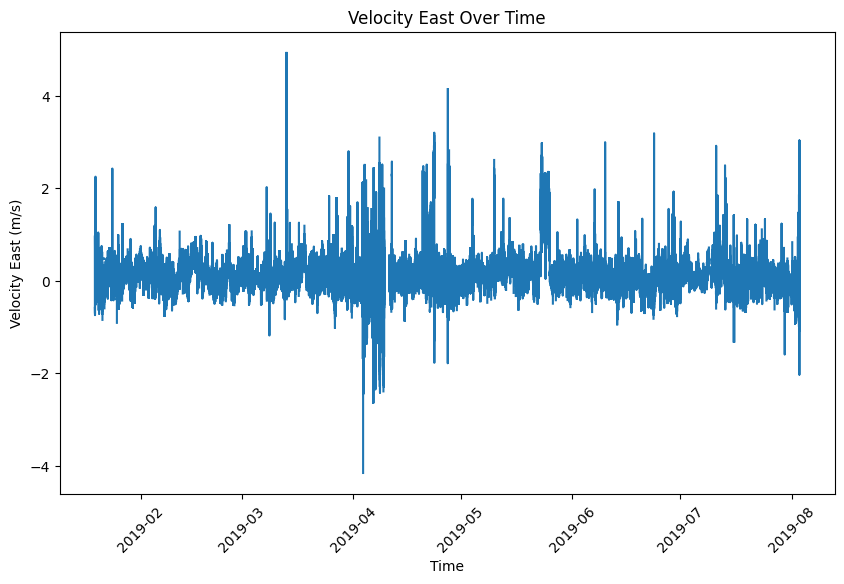

In [15]:

plt.figure(figsize=(10, 6))
plt.plot(df_vel_up['time'], df_vel_up['vel_east'])
plt.title('Velocity East Over Time')
plt.xlabel('Time')
plt.ylabel('Velocity East (m/s)')
plt.xticks(rotation=45)


In [16]:
df_test = df_vel_up.copy()
df_test.reset_index(inplace=True)
df_test.head()

,trajectory,obs,cell_depth,vel_east,time,latitude,longitude
0,1020.0,0,4.2,-0.584,2019-01-19 04:00:00,-46.683172,168.517128
1,1020.0,0,6.2,-0.594,2019-01-19 04:00:00,-46.683172,168.517128
2,1020.0,0,8.2,-0.534,2019-01-19 04:00:00,-46.683172,168.517128
3,1020.0,0,10.2,-0.564,2019-01-19 04:00:00,-46.683172,168.517128
4,1020.0,0,12.2,-0.559,2019-01-19 04:00:00,-46.683172,168.517128


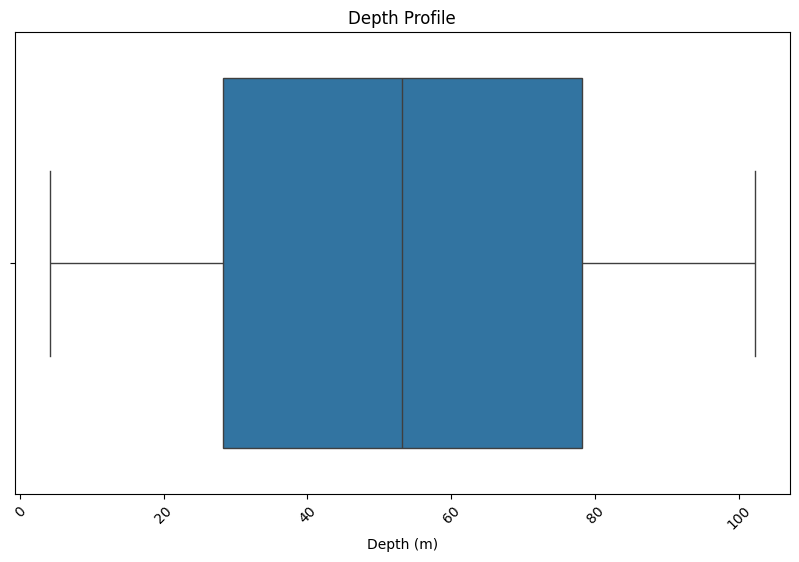

In [17]:
import seaborn as sns

if df_test['cell_depth'].nunique() > 1:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='cell_depth', data=df_test)
    plt.title('Depth Profile')
    plt.xlabel('Depth (m)')
    plt.xticks(rotation=45)